# feature extraction for logistic CVD models
load the predictions for the validation model for each.

and compute the confusion matrix, the precision and f1 score (multiclass)
and roc curve maybe? what curves do we use for multiclass.


In [1]:
# trainer
print("strawberry")
from trustworthai.utils.fitting_and_inference.fitters.basic_lightning_fitter import StandardLitModelWrapper
from trustworthai.utils.fitting_and_inference.get_trainer import get_trainer

# data
from twaidata.torchdatasets.MRI_3D_nolabels_inram_ds import MRI_3D_nolabels_inram_ds

# packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torchinfo import summary
from tqdm import tqdm
from collections import defaultdict
from natsort import natsorted
import torchmetrics
print("banana")

strawberry
banana


In [2]:
import seaborn as sns
import scipy

### Loading predictions

In [3]:
# def get_output_maps_for_ds(output_maps_dir, ids):
#     output_maps_lists = defaultdict(lambda : [])
#     key_order = None
#     for ID in tqdm(ids, position=0, leave=True):
#         output_maps_data = np.load(f"{output_maps_dir}{ID}_out_maps.npz")
#         key_order = natsorted(list(output_maps_data.keys()))
#         for output_type in key_order:
#             output_maps_lists[ID].append(torch.from_numpy(output_maps_data[output_type]))
            
#     return output_maps_lists, key_order
def load_output_maps(output_maps_dir):
    output_maps_lists = defaultdict(lambda: [])
    for fID in tqdm(os.listdir(output_maps_dir), position=0, leave=True):
        # print(fID)
        # break
        if ".npz" in fID:
            ID = fID.split(".")[0]
            output_maps_data = np.load(output_maps_dir+fID)
            key_order = natsorted(list(output_maps_data.keys()))
            for key in key_order:
                output_maps_lists[ID].append(torch.from_numpy(output_maps_data[key]))
    return output_maps_lists, key_order

In [4]:
# model_name = "SSN_Ens_Mean"
model_name = "deterministic"
output_maps_dir = f"/home/s2208943/ipdis/data/preprocessed_data/EdData_output_maps/{model_name}/"
output_maps_for_umaps, key_order = load_output_maps(output_maps_dir)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:39<00:00,  6.44it/s]


In [5]:
# model_name_for_pred = "SSN_Ens_Mean"
model_name_for_pred = "deterministic"
output_maps_dir_for_pred = f"/home/s2208943/ipdis/data/preprocessed_data/EdData_output_maps/{model_name_for_pred}/"
output_maps_for_pred, key_order_for_pred = load_output_maps(output_maps_dir_for_pred)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:26<00:00,  9.66it/s]


In [6]:
key_order

['ent', 'pred', 'seg']

In [7]:
ID = list(output_maps_for_umaps.keys())[2]

In [8]:
img_us = output_maps_for_umaps[ID]
img_ps = output_maps_for_pred[ID]

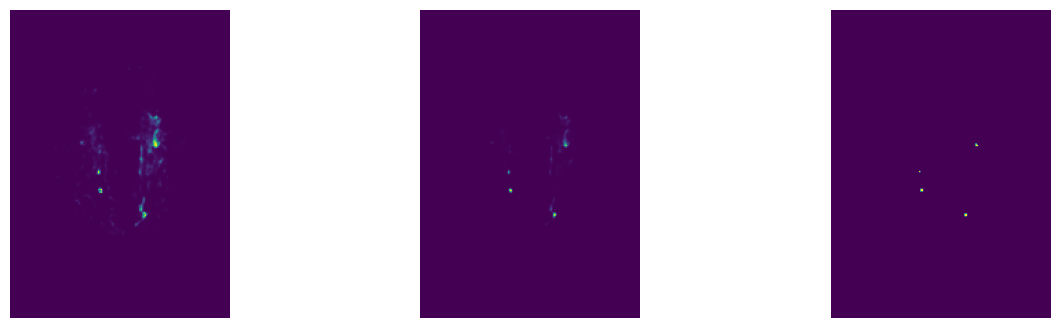

In [9]:
plt.figure(figsize=(15,4))
islice = 31
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(img_us[i][islice])
    plt.axis('off')

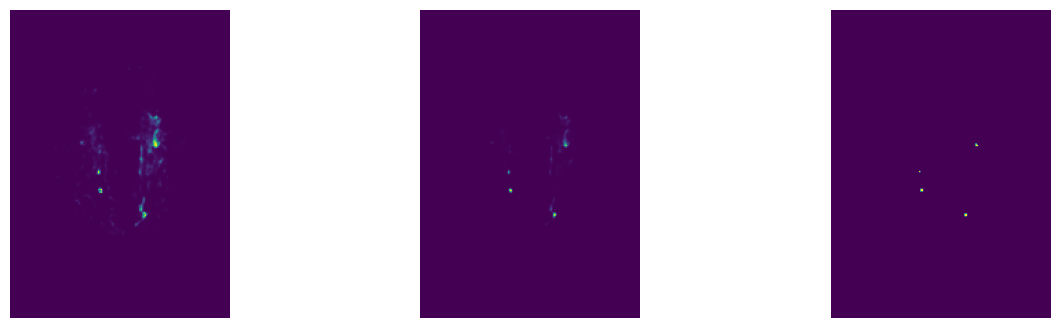

In [10]:
ent, pred, seg = img_ps
plt.figure(figsize=(15,4))
islice = 31
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(img_ps[i][islice])
    plt.axis('off')

In [18]:
t = 0.1
ent_voxels = ent[ent > t]
pred_voxels = pred[pred > t]
# var_voxels = var[var > t/10]

In [19]:
def histogram_distribution(values, bins=20, minv=None, maxv=None):
    # so that the output values are meaningful, I need to carefully set the min a max. mnin should be t, and max should be the max across all the data I think.
    if minv == None:
        minv = values.min()
    if maxv == None:
        maxv = values.max()
    counts = torch.zeros(bins)
    bounds = torch.arange(minv,maxv, (maxv-minv)/bins)
    for i, (lower_bound, upper_bound) in enumerate(zip(bounds[:-1], bounds[1:])):
        counts[i] = ((values >= lower_bound) * (values < upper_bound)).sum()

    Z = counts.sum()
    counts = counts / Z
    return counts

In [20]:
def gaussian_summary_statistics(values):
    sum = values.sum().item()
    mean = values.mean().item()
    std = values.std().item()
    skew = scipy.stats.skew(values)
    kurtosis = scipy.stats.kurtosis(values, fisher=False)
    return sum, mean, std, skew, kurtosis

In [21]:
histogram_distribution(ent_voxels, 20)

tensor([0.1482, 0.1063, 0.0932, 0.0732, 0.0593, 0.0519, 0.0470, 0.0441, 0.0386,
        0.0351, 0.0348, 0.0298, 0.0329, 0.0337, 0.0288, 0.0314, 0.0311, 0.0362,
        0.0444, 0.0000])

In [22]:
# counts, counts.sum()

<Axes: ylabel='Count'>

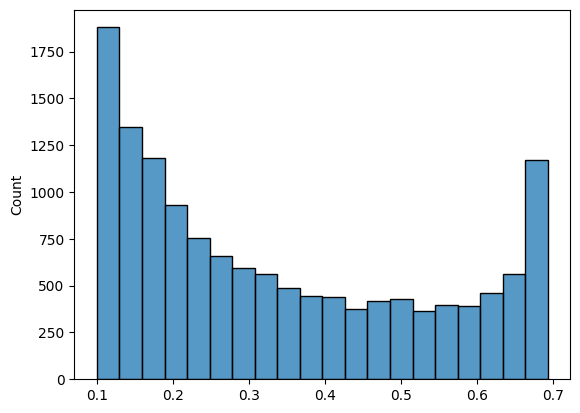

In [23]:
sns.histplot(ent_voxels, bins=20)

### overlap proportions computation
- [x] proportion of segmented area that is uncertain
- [x] proportion of uncertain area that is segmented
- [x] proportion of uncertain area that is within segmentation + edge expansion

In [24]:
def get_edge_expanded_seg(seg, expansions=2):
    expanded = seg.type(torch.float32).unsqueeze(1)
    for _ in range(expansions):
        expanded = torch.nn.functional.max_pool3d(expanded, kernel_size=3, padding=1, stride=1)
    return expanded.type(seg.dtype).squeeze()

### loading the ventricles for ventricle distance analysis

In [25]:
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
import os
import torchvision.transforms as tv

# resamples an image
def get_resampled_img(itk_image, out_spacing=[2.0, 2.0, 2.0], original_spacing=[1., 1., 3.], is_label=False):
    
    if not original_spacing:
        # orig spacing can be specified when the input itk_image does not know its actual spacing.
        original_spacing = itk_image.GetSpacing()
    original_size = itk_image.GetSize()
    
    # what's this? its how to modify the output size I think...
    out_size = [
        int(np.round(orig_size * orig_spacing / out_spacing))
        for (orig_size, orig_spacing, out_spacing) 
        in zip(original_size, original_spacing, out_spacing)
    ]
    
    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size)
    resample.SetOutputDirection(itk_image.GetDirection())      # sets the output direction cosine matrix...
    resample.SetOutputOrigin(itk_image.GetOrigin())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(itk_image.GetPixelIDValue())
    
    if is_label:
        resample.SetInterpolator(sitk.sitkNearestNeighbor)
    else:
        resample.SetInterpolator(sitk.sitkBSpline)
        
    return resample.Execute(itk_image)
      
def resample_and_return(filename_in, is_label=False, out_spacing=[1., 1., 3.], original_spacing=None):
    """
    resamples an image to custom voxel dimensions and returns image as a numpy array
    
    filename_in: .nii.gz file to load
    is_label: is the file a brain scan or a segmentaion mask
    outspacing: the spacing of the image to be resampled to.
    """
        
    # resample the image
    image = sitk.ReadImage(filename_in)
    resampled_image = get_resampled_img(image, out_spacing=out_spacing, original_spacing=original_spacing, is_label=is_label)
    
    return sitk.GetArrayFromImage(resampled_image)

In [26]:
# this loop takes a while as its loading from disk and resampling
# it takes around 11 minutes

cropper = tv.transforms.CenterCrop((224, 160))

def load_fast_output(file, slices):
    timg = resample_and_return(file, is_label=True)
        
    # interpolate the channel number and centre crop
    timg = torch.Tensor(timg)
    timg = torch.nn.functional.interpolate(timg.unsqueeze(0).unsqueeze(0), (slices, *timg.shape[1:])).squeeze()
    timg = cropper(timg.view((1, 1, *timg.shape))).squeeze()
    
    return timg



In [27]:
IDs_outmaps = natsorted(list(output_maps_for_umaps.keys()))
IDs = [("_".join(idx.split("_")[:-2]), idx) for idx in IDs_outmaps if "out_maps" in idx]

In [28]:
IDs_outmaps[0:5], IDs[0:5]

(['CVD001_out_maps',
  'CVD002_out_maps',
  'CVD003_out_maps',
  'CVD004_out_maps',
  'CVD008_out_maps'],
 [('CVD001', 'CVD001_out_maps'),
  ('CVD002', 'CVD002_out_maps'),
  ('CVD003', 'CVD003_out_maps'),
  ('CVD004', 'CVD004_out_maps'),
  ('CVD008', 'CVD008_out_maps')])

In [29]:
output_maps_for_umaps[IDs[0][1]][0].shape

torch.Size([48, 224, 160])

In [30]:
vent_folder = "/home/s2208943/ipdis/data/preprocessed_data/EdData_ventmapper/"
vent_filenames = os.listdir(vent_folder)
ID_ventpath_map = {"_".join(f.split("_")[:-1]): vent_folder + f for f in vent_filenames}
vent_maps = []
for i in tqdm(range(len(IDs)), position=0, leave=True):
    ID = IDs[i]
    num_slices = output_maps_for_umaps[ID[1]][0].shape[0]
    vent_path = ID_ventpath_map[ID[0]]
    vent_seg = load_fast_output(vent_path, num_slices)
    vent_maps.append(vent_seg)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:20<00:00, 12.39it/s]


In [31]:
vent_maps[0].shape, vent_maps[0].sum(dim=(1,2,)).argmax(0)

(torch.Size([48, 224, 160]), tensor(29))

torch.Size([56, 224, 160])
torch.Size([56, 224, 160])


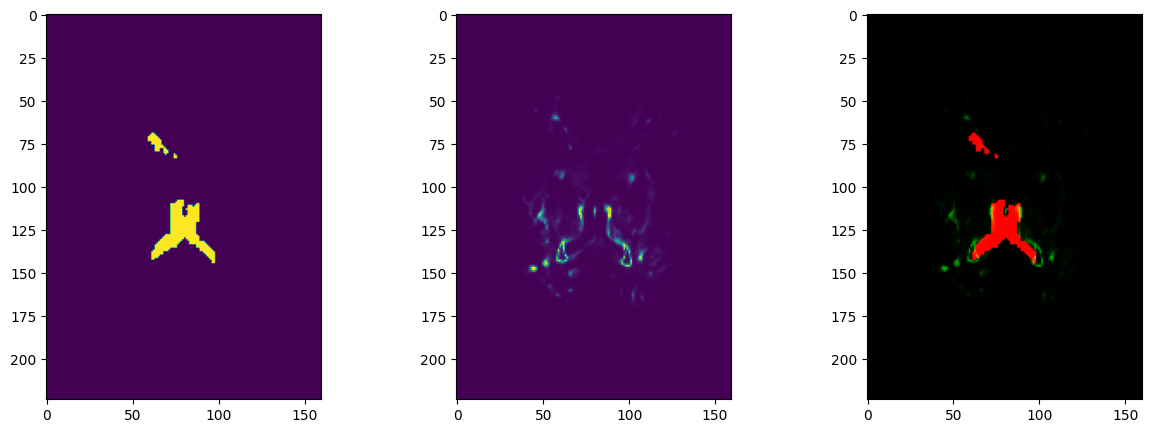

In [32]:
islice = 32
scan_id = 200
plt.figure(figsize=(15, 5))
plt.subplot(1,3,1)
plt.imshow(vent_maps[scan_id][islice])
plt.subplot(1,3,2)
plt.imshow(output_maps_for_umaps[IDs[scan_id][1]][0][islice])
plt.subplot(1,3,3)
img_map = torch.zeros(*vent_maps[scan_id].shape[1:], 3)
print(output_maps_for_umaps[IDs[scan_id][1]][0].shape)
print(vent_maps[scan_id].shape)
img_map[:,:,0] = vent_maps[scan_id][islice]
img_map[:,:,1] = output_maps_for_umaps[IDs[scan_id][1]][0][islice]
plt.imshow(img_map)

### distance from the ventricles

In [33]:
import torch.nn.functional as F
def edge_pixels_3D(img):
    dtype = img.dtype # preserve original datatype for casting at the end
    img = img.type(torch.float32).unsqueeze(0)
    
    max_pool = F.max_pool3d(img, 3, stride=1, padding=1)
    outer_edge = (max_pool != img).type(torch.float32)
    
    dilated_edge = F.max_pool3d(outer_edge, 3, stride=1, padding=1)
    inner_edge = dilated_edge * img
    
    return inner_edge.type(dtype).squeeze()

def edge_pixels(img):
    dtype = img.dtype # preserve original datatype for casting at the end
    img = img.type(torch.float32)
    
    max_pool = F.max_pool2d(img, 3, stride=1, padding=1)
    outer_edge = (max_pool != img).type(torch.float32)
    
    dilated_edge = F.max_pool2d(outer_edge, 3, stride=1, padding=1)
    inner_edge = dilated_edge * img
    
    return inner_edge.type(dtype)

In [34]:
def downsample_3d(img, avg=True):
    if avg:
        return F.avg_pool3d(img.unsqueeze(0).type(torch.float32), 2, stride=2).squeeze().type(img.dtype)
    else:
        return F.max_pool3d(img.unsqueeze(0).type(torch.float32), 2, stride=2).squeeze().type(img.dtype)

In [35]:
def min_distances(img, vmap):
    # calculate the minimum distance between each point in a and each point in b
    
    spatial_dims = vmap.squeeze().shape
    grid = torch.stack(
            torch.meshgrid(
                *[torch.arange(0, sdi, 1) for sdi in spatial_dims],
                indexing='ij'
            )
        ).type(torch.float32).to(img.device)
    
    a = grid[:, img.squeeze() > 0].T.cuda()
    b = grid[:, vmap.squeeze() > 0].T.cuda()
    
    # Calculate pairwise distances between all pairs of points
    distances = torch.cdist(a, b)

    # Find indices of closest points in b for each point in a
    _, indices = torch.min(distances, dim=1)

    # Use indices to index into b and get closest points
    b_closest = b[indices]

    # Calculate distances to closest points 
    distances_closest = torch.norm(a - b_closest, dim=1)
    
    distance_map = torch.zeros(img.shape).to(distances_closest.device)
    distance_map[img > 0] = distances_closest
    
    return distances_closest, distance_map

### connected components analysis

In [36]:
import cc3d

In [37]:
def get_conn_comps(img):
    connectivity = 6 # only 4,8 (2D) and 26, 18, and 6 (3D) are allowed
    labels_out_seg = cc3d.connected_components(img.cpu().numpy(), connectivity=connectivity)
    return torch.from_numpy(labels_out_seg.astype(np.int16)).to(img.device)

In [38]:
def get_edge_expanded_seg(seg, expansions=2):
    expanded = seg.type(torch.float32).unsqueeze(1)
    for _ in range(expansions):
        expanded = torch.nn.functional.max_pool3d(expanded, kernel_size=3, padding=1, stride=1)
    return expanded.type(seg.dtype).squeeze()

In [39]:
def skew(t, dim=None):
    """
    Computes the skewness of a :class:`Tensor`. Note: this function uses cross-approximation (:func:`tntorch.cross()`).

    :param t: a :class:`Tensor`

    :return: a scalar
    """

    return (((t-t.mean(dim=dim).unsqueeze(dim))/t.std(dim=dim).unsqueeze(dim)).pow(3)).mean(dim=dim)


def kurtosis(t, fisher=True, dim=None):
    """
    Computes the kurtosis of a :class:`Tensor`. Note: this function uses cross-approximation (:func:`tntorch.cross()`).

    :param t: a :class:`Tensor`
    :param fisher: if True (default) Fisher's definition is used, otherwise Pearson's (aka excess)

    :return: a scalar
    """
        
    return (((t-t.mean(dim=dim).unsqueeze(dim))/t.std(dim=dim).unsqueeze(dim)).pow(4)).mean(dim=dim) - fisher*3

In [40]:
def one_hot_encoded_image(image):
    # for a 3D [H, W, D] shape image
    # ensure all IDs are unique
    return (image == image.unique().view(-1, 1, 1, 1))

def one_hot_encoded_vector(vector):
    return (vector == vector.unique().view(-1,1))

In [41]:
def conn_comp_basic_stats(umap, conn_comp_map, seg_map, dist_map):
    # number of connected components
    # size of connected components
    # connected component size distribution information
    cc_ids = conn_comp_map.unique()
    cc_locs = conn_comp_map != 0
    conn_comp_map = conn_comp_map[cc_locs]
    umap = umap[cc_locs]
    seg_map = seg_map[cc_locs]
    dist_map = dist_map[cc_locs]
    
    assert dist_map.shape == seg_map.shape == umap.shape == conn_comp_map.shape
    num_ccs = len(cc_ids) - 1
    num_ccs_no_overlap = 0
    cc_sizes = []
    cc_means = []
    cc_stds = []
    cc_skews = []
    cc_kurts = []
    cc_vent_dists = []
    for cc_id in cc_ids:
        if cc_id == 0:
            continue
        cc = conn_comp_map == cc_id
        cc_size = cc.sum().item()
        cc_values = umap[cc]
        _, mean, std, skew, kurtosis = gaussian_summary_statistics(cc_values.cpu())
    
        cc_sizes.append(cc_size)
        cc_means.append(mean)
        cc_stds.append(std)
        cc_skews.append(skew)
        cc_kurts.append(kurtosis)
        
        if seg_map[cc].sum() == 0:
            num_ccs_no_overlap += 1
            
        cc_vent_dists.append(dist_map[cc].mean().item())
    _, vd_mean, vd_std, vd_skew, vd_kurt = gaussian_summary_statistics(torch.Tensor(cc_vent_dists))
    _, size_mean, size_std, size_skew, size_kurt = gaussian_summary_statistics(torch.Tensor(cc_sizes))
    
    return {"num":num_ccs, "sizes":cc_sizes, "means":cc_means, "stds":cc_stds, "skews":cc_skews, "kurts":cc_kurts, "vent_dists":cc_vent_dists, "unsegmented_ccs":num_ccs_no_overlap, "size_mean":size_mean, "size_std":size_std, "size_skew":size_skew, "size_kurt":size_kurt, "vd_mean":vd_mean, "vd_std":vd_std, "vd_skew":vd_skew, "vd_kurt":vd_kurt}



In [42]:
# idx = 0
# example_umap = output_maps_for_umaps[IDs[idx][1]][0].cuda()
# example_smap = output_maps_for_pred[IDs[idx][1]][2].cuda()
# example_vmap = vent_maps[idx].cuda()

# vmap_ds = downsample_3d(example_vmap)
# umap_ds = downsample_3d(example_umap)
# ut_ds = umap_ds > 0.1
# ut = example_umap > 0.1
# conn_comps = get_conn_comps(ut)

# distances_closest, distance_map = min_distances(ut_ds, vmap_ds)
# distance_map = F.interpolate(distance_map.view(1, 1, *distance_map.shape), example_umap.shape, mode='trilinear').squeeze()

In [43]:
# cc_data = conn_comp_basic_stats(example_umap, conn_comps, example_smap, distance_map) # from this we could get the mean mean, mean std, mean skew and mean kurtosis for each threshold I guess. # that would be somewhat interesting

In [44]:
# cc_data["num"], cc_data["unsegmented_ccs"]

In [45]:
# cc_data["log_sizes"] = torch.Tensor(cc_data['sizes']).log()
# sns.jointplot(cc_data, y="vent_dists", x="log_sizes", bins=5, kind='hist')

In [46]:
def joint_hist_values(data, x, y, minx, maxx, miny, maxy, bins=5):
    values = torch.stack([torch.Tensor(data[x]), torch.Tensor(data[y])], dim=1) # shape [N, 2]
    values = values.expand((bins, bins, *values.shape))
    counts = torch.zeros(bins, bins)
    bounds_x = torch.arange(minx,maxx, (maxx-minx)/(bins+1)).to(values.device)
    bounds_y = torch.arange(miny,maxy, (maxy-miny)/(bins+1)).to(values.device)
    upper_xlims = bounds_x[1:].view(1, 5, 1)
    upper_ylims = bounds_y[1:].view(5, 1, 1)
    lower_xlims = bounds_x[:-1].view(1, 5, 1)
    lower_ylims = bounds_y[:-1].view(5, 1, 1)
    counts = (values[:,:,:,0] < upper_xlims) * (values[:,:,:,0] > lower_xlims) * (values[:,:,:,1] < upper_ylims) * (values[:,:,:,1] > lower_ylims)
    counts = counts.sum(dim=-1)

    Z = counts.sum()
    counts = counts / Z
    return counts


# def joint_hist_values2(data, x, y, minx, maxx, miny, maxy, bins=5):
#     values = torch.stack([torch.Tensor(data[x]), torch.Tensor(data[y])], dim=1) # shape [N, 2]
#     #values = values.expand((bins, bins, *values.shape))
#     counts = torch.zeros(bins, bins)
#     bounds_x = torch.arange(minx,maxx, (maxx-minx)/(bins+1))
#     bounds_y = torch.arange(miny,maxy, (maxy-miny)/(bins+1))
#     upper_xlims = bounds_x[1:]
#     upper_ylims = bounds_y[1:]
#     lower_xlims = bounds_x[:-1]
#     lower_ylims = bounds_y[:-1]
#     for i, (x1, x2) in enumerate(zip(lower_xlims, upper_xlims)):
#         for j, (y1,y2) in enumerate(zip(lower_ylims, upper_ylims)):
#             counts[i][j] = ((values[:,0] < x2) * (values[:,0] > x1) * (values[:,1] < y2) * (values[:,1] > y1)).sum()
#     # counts = counts.sum(dim=-1)

#     Z = counts.sum()
#     counts = counts / Z
#     return counts

In [47]:
# joint_counts = joint_hist_values2(cc_data, "log_sizes", "vent_dists", 0, 8, 0, 10, 5)

In [48]:
# joint_counts.shape

In [49]:
# plt.imshow(joint_counts); plt.colorbar()

In [50]:
# cc_data["num"], cc_data["unsegmented_ccs"]

In [51]:
# summary statistics of log conn comp size:
# cc_summary_stats = gaussian_summary_statistics(torch.Tensor(cc_data['sizes']).log())

In [52]:
# sum, mean , std, skew, kurtosis of log size of connected components.
# cc_summary_stats

In [53]:
# histogram_distribution(torch.Tensor(cc_data['sizes']).log(), 10)

In [54]:
# plt.hist(torch.Tensor(cc_data['sizes']).log(), bins=10);

In [55]:
# sns.jointplot(data=cc_data, x="sizes", y="kurts")
# plt.xscale('log')

In [56]:
# lets get basic distribution of connected component numbers and size. Then we can get some interesting plots later, so collect as much interesting information as possible...
# I can compare this to number and size of connected components in the predicted map (at say tau > 0.5?)
# I should get distance of each connected component from the ventricles and size. yes that is a good plot
# also distance from the binarized segmentation... (but I need to be careful and do this for pred as well as umap).

### Uncertainty values that I intended to extract from the umap

For SSN Ens for the ent and var maps, and SSN Ens Mean for the pred and seg maps. Nice.
I should capture all of these metrics across a variety of metrics, and I can tune the thresholds in cross validation. simples.
It may be the case that ent + var together give us some more information. That would be interesting.

`output_maps_for_umaps` is the SSN_Ens output
`output_maps_for_mean` is the SSN_Ens_mean output

- [x] sum
- [x] mean
- [x] std
- [x] skew
- [x] kurtosis
- [x] kde bins?
- [x] ventricle size
- [x] intensity distribution (need to ensure that the min and max of the bins are the same across all individuals) 
- [x] number of connected components
- [x] size of connected components distribution, need to ensure that the min and max of the bins are the same across all individuals.
- [x] number / distribution of connected components that have no overlap with the segmented mask... (again I need the umap and the pred map to do this) (and I should also compare to the seg map as well perhaps)
- [x] uncertainty sum, mean, skew, kurtosis of each connected component. That may be interesting to plot.
- [-] distance to the WMH binarized segmentation for each connected component (try to separate out those connected components that are highlighting other stuff).
- [-] proportion of the segmented edge deemed uncertain (if we expand the edge of the segmentation then calculate the proportion, we can get the sum of the uncertainty that
- [x] proportion of segmented area deemed uncertain (this requires access to SSN Ens and SSN Ens Mean at the same time
- [x] proportion of uncertain area that is within the segmentation + edge area
- [x] distribution of size of connected components (sum, mean, std, skew)
- [x] distance from the ventricles (could do this in x, y and z distributions, or just overall...) I could measure distance x intensity
- [x] stats for distance from the ventricles (mean, std, skew, kurtosis, etc)
- [x] mean distance from the ventricles of each connected component joint with size in a 5x5 and 10x10 bin option I think. again ensure that the 
- [ ] predicted seg volume.

### turning all of the above into a big loop

need to compute values for:
- [x] ent map
- [x] var map
- [x] pred map
- [x] loop over [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5] as threshold for ent map
- [x] loop over [0.1, 0.2, 0.3, 0.4, 0.5, 0.6] for pred map
- [x] loop over ? for ent map

In [57]:
data = {}
failed_ids = []
for idx in tqdm(range(len(IDs)), position=0, leave=True):
    ID = IDs[idx][0]
    print(ID)
    try:
        vmap = vent_maps[idx].cuda()
        smap = output_maps_for_pred[IDs[idx][1]][2].cuda()
        smap_expanded = get_edge_expanded_seg(smap)
        seg_volume = smap.sum().item()
        vent_volume = vmap.sum().item()
        vmap_ds = downsample_3d(vmap)

        ind_data = {}

        for input_type in ["ent", "pred"]:
            if input_type == "ent":
                umap = output_maps_for_umaps[IDs[idx][1]][0].cuda()
                ts = [0.1, 0.2, 0.3, 0.4, 0.45, 0.5]
                maxv = 0.7
            # elif input_type == "var":
            #     umap = output_maps_for_umaps[IDs[idx][1]][3].cuda()
            #     ts = [0.01, 0.03, 0.06, 0.09, 0.12, 0.15]
            #     maxv = 0.2
            elif input_type == "pred":
                umap = output_maps_for_pred[IDs[idx][1]][1].cuda()
                ts = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
                maxv = 1.0
            else:
                raise ValueError  

            umap_ds = downsample_3d(umap)

            collected_data_t = {}

            for t in ts:
                ut = umap > t
                umap_values = umap[ut]

                #### summary statistics
                sum, mean, std, skew, kurtosis = gaussian_summary_statistics(umap_values.cpu())
                values_hist = histogram_distribution(umap_values, bins=20, minv=t, maxv=maxv)

                #### overlap statistics
                intersection = (ut * smap).sum()
                expanded_intersection = (ut * smap_expanded).sum()

                prop_umap_segmented = (intersection / ut.sum()).item()
                prop_umap_within_expanded_seg = (expanded_intersection / ut.sum()).item()
                prop_seg_uncertain = (intersection / smap.sum()).item()

                ### ventricle distance statistics
                ut_ds = umap_ds > t
                distances_closest, distance_map = min_distances(ut_ds, vmap_ds)
                distance_map = F.interpolate(distance_map.view(1, 1, *distance_map.shape), umap.shape, mode='trilinear').squeeze()
                _, dist_mean, dist_std, dist_skew, dist_kurt = gaussian_summary_statistics(distances_closest.cpu())
                umap_ds_values = umap_ds[ut_ds]
                dist_value_joint = joint_hist_values({"x":distances_closest, "y":umap_ds_values}, x="x", y="y", minx=0, maxx=30, miny=t, maxy=maxv, bins=5).cpu()

                ### connected component analysis statistics
                conn_comps = get_conn_comps(ut)
                cc_data = conn_comp_basic_stats(umap, conn_comps, smap, distance_map)
                cc_data["log_sizes"] = torch.Tensor(cc_data["sizes"]).log()
                cc_size_dist_joint = joint_hist_values(cc_data, "log_sizes", "vent_dists", 0, 8, 0, 10, 5).cpu()

                # recorded values
                all_data = {}
                for key, value in cc_data.items():
                    all_data["cc_" + key] = value
                all_data["sum"] = sum
                all_data["mean"] = mean
                all_data["std"] = std
                all_data["skew"] = skew
                all_data["kurtosis"] = kurtosis
                all_data["prop_umap_segmented"] = prop_umap_segmented
                all_data["prop_umap_within_expanded_seg"] = prop_umap_within_expanded_seg
                all_data["prop_seg_uncertain"] = prop_seg_uncertain
                all_data["dist_mean"] = dist_mean
                all_data["dist_std"] = dist_std
                all_data["dist_skew"] = dist_skew
                all_data["dist_kurt"] = dist_kurt
                all_data["dist_value_joint"] = dist_value_joint
                all_data["cc_dist_value_joint"] = cc_size_dist_joint
                all_data["seg_volume"] = seg_volume
                all_data["vent_volume"] = vent_volume
                all_data["values_hist"] = values_hist

                print(all_data["cc_num"], all_data["cc_unsegmented_ccs"])
                collected_data_t[str(t)] = all_data


                # break

            ind_data[input_type] = collected_data_t
            # break

        data[ID] = ind_data
        # break
    except:
        failed_ids.append((idx, ID))
    # break
        

  0%|                                                                                                                                                                 | 0/250 [00:00<?, ?it/s]

CVD001


/tmp/ipykernel_2830806/1284179010.py:5: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = scipy.stats.skew(values)
/tmp/ipykernel_2830806/1284179010.py:6: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = scipy.stats.kurtosis(values, fisher=False)


69 68
57 56
64 63
71 68
73 69
79 70
63 62
75 70
66 54
85 60


  0%|▌                                                                                                                                                        | 1/250 [00:02<09:16,  2.24s/it]

63 0
64 0
CVD002
182 177
109 102
88 72
100 59
143 65
197 75
75 64
54 40
36 20
38 17


  1%|█▏                                                                                                                                                       | 2/250 [00:04<09:00,  2.18s/it]

33 0
32 0
CVD003
151 138
113 90
201 110
493 165
733 210
1044 306
100 81
75 50
64 32
56 16


  1%|█▊                                                                                                                                                       | 3/250 [00:10<15:32,  3.78s/it]

50 0
39 0
CVD004
155 146
105 94
85 72
70 42
90 48
108 53
77 65
54 34
58 34


  2%|██▍                                                                                                                                                      | 4/250 [00:11<12:24,  3.03s/it]

44 14
40 0
37 0
CVD008
90 76
90 61
132 67
260 95
412 147
617 219
64 36
65 33
58 23
50 6
54 0


  2%|███                                                                                                                                                      | 5/250 [00:15<13:20,  3.27s/it]

60 0
CVD009
275 270
203 187
201 155
249 141
305 136
408 161
157 132
113 82
79 44
75 33
51 0


  2%|███▋                                                                                                                                                     | 6/250 [00:19<14:44,  3.62s/it]

49 0
CVD011
186 174
141 127
130 110
143 102
126 81
173 101
110 95
91 69
88 54
84 41


  3%|████▎                                                                                                                                                    | 7/250 [00:22<13:39,  3.37s/it]

61 0
54 0
CVD012
174 167
125 113
94 76
117 76
142 71
206 81
80 64
62 41
52 25
50 14
46 0


  3%|████▉                                                                                                                                                    | 8/250 [00:25<12:32,  3.11s/it]

51 0
CVD013
87 79
67 58
76 54
86 38
115 51
157 58
55 40
49 30
42 20
35 9


  4%|█████▌                                                                                                                                                   | 9/250 [00:27<10:44,  2.67s/it]

32 0
30 0
CVD014
137 134
122 113
106 92
97 78
110 78
128 77
103 88
75 55
64 36
58 19
52 0


  4%|██████                                                                                                                                                  | 10/250 [00:29<10:03,  2.51s/it]

46 0
CVD016
154 141
124 103
122 81
195 90
372 141
645 201
91 67
87 53
86 40
72 20
59 0


  4%|██████▋                                                                                                                                                 | 11/250 [00:33<11:37,  2.92s/it]

51 0
CVD017
200 191
115 105
90 79
86 68
95 67
103 62
71 60
63 47
44 22


  5%|███████▎                                                                                                                                                | 12/250 [00:35<10:31,  2.65s/it]

46 15
43 0
34 0
CVD018
89 84
57 52
52 47
66 61
57 52
54 48
61 56
51 46
29 23


/home/s2208943/miniconda3/envs/wmh/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1304: RuntimeWarning: Mean of empty slice.
  mean = a.mean(axis, keepdims=True)
/home/s2208943/miniconda3/envs/wmh/lib/python3.8/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/s2208943/miniconda3/envs/wmh/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/s2208943/miniconda3/envs/wmh/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/home/s2208943/miniconda3/envs/wmh/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1417: RuntimeWarning: Mean of empty slice.
  mean = a.mean(axis, keepdims=True)
  5%|███████▉                                                                                                                         

18 10
8 0
4 0
CVD019
108 96
82 67
73 56
82 56
87 54
99 54
61 45
49 30
38 17


  6%|████████▌                                                                                                                                               | 14/250 [00:38<08:07,  2.07s/it]

28 4
27 0
21 0
CVD020
200 171
174 129
198 120
310 143
430 176
599 212
147 97
124 64
101 35
96 21


  6%|█████████                                                                                                                                               | 15/250 [00:42<11:23,  2.91s/it]

92 0
80 0
CVD021
204 184
153 123
133 100
157 93
200 102
255 110
125 91
92 50
80 35
71 19


  6%|█████████▋                                                                                                                                              | 16/250 [00:45<11:32,  2.96s/it]

59 0
63 0
CVD023
164 150
111 92
112 70
191 75
277 94
432 136
72 50
55 27
38 8
38 7


  7%|██████████▎                                                                                                                                             | 17/250 [00:48<11:31,  2.97s/it]

34 0
31 0
CVD024
222 213
124 112
91 73
115 71
141 67
173 74
75 60
55 37
37 17
31 7


  7%|██████████▉                                                                                                                                             | 18/250 [00:51<10:35,  2.74s/it]

31 0
29 0
CVD025
75 67
72 59
100 51
395 106
746 188
1203 315
48 37
41 28
29 15
24 6


  8%|███████████▌                                                                                                                                            | 19/250 [00:56<13:20,  3.47s/it]

25 0
26 0
CVD028
132 119
133 109
230 111
609 190
983 290
1423 384
95 69
69 32
75 29
66 11
69 0


  8%|████████████▏                                                                                                                                           | 20/250 [01:03<17:38,  4.60s/it]

74 0
CVD030
121 109
71 59
71 56
83 65
87 58
100 67
67 54
63 46
45 25
35 9
31 0


  8%|████████████▊                                                                                                                                           | 21/250 [01:05<14:23,  3.77s/it]

35 0
CVD031
229 220
142 125
121 94
133 78
217 89
373 125
114 90
80 46
81 34
85 23


  9%|█████████████▍                                                                                                                                          | 22/250 [01:08<13:49,  3.64s/it]

78 0
71 0
CVD032
140 131
121 106
113 83
133 66
165 71
229 91
83 65
64 40
50 20


  9%|█████████████▉                                                                                                                                          | 23/250 [01:11<12:24,  3.28s/it]

51 12
47 0
44 0
CVD033
192 177
138 105
174 100
322 125
432 145
564 159
117 80
80 38
68 19
65 11


 10%|██████████████▌                                                                                                                                         | 24/250 [01:15<13:27,  3.57s/it]

62 0
61 0
CVD034
206 186
155 124
186 115
311 135
403 150
519 193
113 78
105 64
80 36
69 18
59 0


 10%|███████████████▏                                                                                                                                        | 25/250 [01:19<14:11,  3.79s/it]

56 0
CVD035
137 133
73 65
48 37
64 41
79 42
93 44
51 42
40 27
35 21


 10%|███████████████▊                                                                                                                                        | 26/250 [01:21<11:31,  3.09s/it]

25 8
21 0
23 0
CVD036
107 93
99 74
152 81
440 155
766 230
1174 335
80 49
65 31
61 22
55 12
46 0


 11%|████████████████▍                                                                                                                                       | 27/250 [01:26<14:29,  3.90s/it]

43 0
CVD037
78 78
38 38
19 19
21 21
19 19


 11%|█████████████████                                                                                                                                       | 28/250 [01:27<10:47,  2.92s/it]

16 16
14 14
16 16
6 6
1 1
0 0
0 0
CVD038
149 135
116 93
118 81
146 64
194 67
260 87
86 58
70 36
66 27
67 18
58 0


 12%|█████████████████▋                                                                                                                                      | 29/250 [01:30<10:31,  2.86s/it]

55 0
CVD039
178 165
105 81
138 84
274 105
406 145
538 182
92 58
83 43
70 24
63 10
63 0


 12%|██████████████████▏                                                                                                                                     | 30/250 [01:34<11:38,  3.17s/it]

64 0
CVD040
142 132
157 139
120 88
202 88
320 131
501 179
91 72
77 49
67 32
67 24
54 0


 12%|██████████████████▊                                                                                                                                     | 31/250 [01:37<12:08,  3.33s/it]

48 0
CVD041
120 111
94 82
106 67
353 136
553 191
830 266
65 48
54 37
43 21
38 14


 13%|███████████████████▍                                                                                                                                    | 32/250 [01:42<13:25,  3.69s/it]

32 0
35 0
CVD042
187 178
103 94
86 74
83 59
90 52
103 56
76 65
41 30
37 23


 13%|████████████████████                                                                                                                                    | 33/250 [01:44<11:18,  3.13s/it]

30 14
22 0
19 0
CVD043
149 144
79 69
98 67
137 70
195 90
255 104
75 59
56 38
47 29
32 12


 14%|████████████████████▋                                                                                                                                   | 34/250 [01:46<10:30,  2.92s/it]

28 0
24 0
CVD045
116 91
145 105
246 127
552 198
881 279
1194 359
111 67
95 47
92 32
83 14


 14%|█████████████████████▎                                                                                                                                  | 35/250 [01:53<14:34,  4.07s/it]

84 0
76 0
CVD047
364 336
265 227
303 214
349 184
404 186
447 197
223 175
153 99
146 72
123 37
115 0


 14%|█████████████████████▉                                                                                                                                  | 36/250 [01:58<16:05,  4.51s/it]

108 0
CVD048
257 223
228 178
247 156
388 183
515 197
683 232
152 105
129 64
107 35
101 22
100 0


 15%|██████████████████████▍                                                                                                                                 | 37/250 [02:04<17:13,  4.85s/it]

96 0
CVD049
134 126
115 101
107 81
147 92
161 84
190 87
99 82
74 52
60 35


 15%|███████████████████████                                                                                                                                 | 38/250 [02:07<14:40,  4.15s/it]

49 19
42 0
34 0
CVD050
140 124
108 77
110 71
126 66
176 82
249 100
89 51
85 36
83 26
73 13
72 0


 16%|███████████████████████▋                                                                                                                                | 39/250 [02:09<13:07,  3.73s/it]

65 0
CVD052
357 257
329 203
362 181
510 216
593 239
687 268
250 125
214 79
194 48
182 30
164 0


 16%|████████████████████████▎                                                                                                                               | 40/250 [02:17<16:46,  4.79s/it]

146 0
CVD055
237 222
162 141
123 97
103 73
107 75
108 71
103 83
72 50
48 23
40 11
32 0


 16%|████████████████████████▉                                                                                                                               | 41/250 [02:19<14:16,  4.10s/it]

28 0
CVD056
161 152
118 99
106 84
102 69
103 66
112 65
93 78
64 44
46 25
32 10


 17%|█████████████████████████▌                                                                                                                              | 42/250 [02:21<12:04,  3.48s/it]

29 0
26 0
CVD060
140 111
129 77
158 76
343 136
479 174
659 237
123 61
123 47
114 25
122 21
111 0


 17%|██████████████████████████▏                                                                                                                             | 43/250 [02:26<13:33,  3.93s/it]

107 0
CVD061
144 135
126 104
140 94
201 101
261 122
369 141
98 67
96 57
83 37
76 17
76 0


 18%|██████████████████████████▊                                                                                                                             | 44/250 [02:30<12:55,  3.76s/it]

80 0
CVD063
290 272
185 154
166 122
175 101
204 104
210 95
135 105
89 51
78 31
64 9


 18%|███████████████████████████▎                                                                                                                            | 45/250 [02:33<12:18,  3.60s/it]

65 0
54 0
CVD064
83 81
70 66
79 58
127 72
212 91
415 132
60 47
46 28
44 19
44 15


 18%|███████████████████████████▉                                                                                                                            | 46/250 [02:35<11:06,  3.27s/it]

38 0
43 0
CVD065
116 93
108 78
108 72
214 93
379 132
616 197
87 60
66 37
55 23
44 6
46 0


 19%|████████████████████████████▌                                                                                                                           | 47/250 [02:39<11:22,  3.36s/it]

44 0
CVD068
197 187
139 122
147 107
184 99
232 110
280 116
105 83
80 50
70 37
60 19


 19%|█████████████████████████████▏                                                                                                                          | 48/250 [02:42<11:00,  3.27s/it]

51 0
45 0
CVD070
149 143
97 85
113 81
209 96
288 104
384 122
87 69
66 43
63 29
58 17
53 0


 20%|█████████████████████████████▊                                                                                                                          | 49/250 [02:45<10:47,  3.22s/it]

50 0
CVD073
226 203
162 134
154 113
188 104
230 112
273 115
133 97
113 66
87 37
75 16
67 0


 20%|██████████████████████████████▍                                                                                                                         | 50/250 [02:48<10:49,  3.25s/it]

71 0
CVD074
122 108
107 92
76 55
84 52
120 63
158 66
63 46
51 29
58 29


 20%|███████████████████████████████                                                                                                                         | 51/250 [02:50<09:31,  2.87s/it]

58 21
48 0
40 0
CVD075
220 212
138 128
108 92
97 64
93 55
96 48
98 83
53 38
30 14


 21%|███████████████████████████████▌                                                                                                                        | 52/250 [02:52<08:38,  2.62s/it]

25 7
25 0
23 0
CVD076
160 132
156 109
183 90
319 137
419 169
506 197
105 58
114 56
99 35
99 25
80 0


 21%|████████████████████████████████▏                                                                                                                       | 53/250 [02:57<10:15,  3.13s/it]

73 0
CVD077
205 199
155 143
148 115
227 110
375 148
595 207
111 97
74 56
57 38
51 22


 22%|████████████████████████████████▊                                                                                                                       | 54/250 [03:01<10:59,  3.36s/it]

43 0
38 0
CVD078
142 115
117 81
127 77
165 89
184 95
187 87
100 63
78 40
69 24


 22%|█████████████████████████████████▍                                                                                                                      | 55/250 [03:03<10:07,  3.12s/it]

55 7
51 0
41 0
CVD079
338 326
190 175
152 130
140 103
132 86
130 69
131 115
65 47
48 28
43 15
33 0


 22%|██████████████████████████████████                                                                                                                      | 56/250 [03:06<09:40,  2.99s/it]

22 0
CVD080
177 167
107 89
119 76
127 60
149 69
175 73
87 67
74 48
58 30


 23%|██████████████████████████████████▋                                                                                                                     | 57/250 [03:08<08:56,  2.78s/it]

46 16
32 0
23 0
CVD081
181 174
104 93
82 64
97 54
121 64
176 80
72 59
49 32
46 23
44 16


 23%|███████████████████████████████████▎                                                                                                                    | 58/250 [03:10<08:13,  2.57s/it]

37 0
33 0
CVD082
208 202
141 131
110 97
105 81
101 67
100 59
103 92
46 35
28 14


 24%|███████████████████████████████████▊                                                                                                                    | 59/250 [03:12<07:41,  2.42s/it]

25 7
26 0
20 0
CVD083
273 264
189 170
200 156
307 162
440 210
641 253
154 128
133 95
97 52
79 23
68 0


 24%|████████████████████████████████████▍                                                                                                                   | 60/250 [03:17<09:58,  3.15s/it]

61 0
CVD084
237 214
175 151
148 113
164 97
207 96
234 92
121 97
81 53
58 28
58 19


 24%|█████████████████████████████████████                                                                                                                   | 61/250 [03:20<09:57,  3.16s/it]

47 0
43 0
CVD085
252 238
157 138
131 107
120 74
153 87
183 94
124 101
77 53
61 33
47 15


 25%|█████████████████████████████████████▋                                                                                                                  | 62/250 [03:23<09:31,  3.04s/it]

43 0
39 0
CVD086
184 165
113 90
105 71
149 75
180 76
233 90
91 65
77 46
63 30
53 14
45 0


 25%|██████████████████████████████████████▎                                                                                                                 | 63/250 [03:26<09:18,  2.98s/it]

33 0
CVD088
213 202
154 140
145 92
241 113
317 134
377 146
90 71
67 43
60 33


 26%|██████████████████████████████████████▉                                                                                                                 | 64/250 [03:29<09:47,  3.16s/it]

46 15
39 0
33 0
CVD089
181 166
144 119
135 95
183 92
242 99
318 112
101 75
68 36
64 20
66 15
61 0


 26%|███████████████████████████████████████▌                                                                                                                | 65/250 [03:33<09:41,  3.14s/it]

55 0
CVD090
152 138
105 84
104 67
142 63
177 68
198 76
84 59
60 33
54 25


 26%|████████████████████████████████████████▏                                                                                                               | 66/250 [03:35<08:51,  2.89s/it]

39 10
37 0
35 0
CVD091
232 226
117 110
90 82
67 53
69 46
82 46
81 74
51 40
32 20
21 6
25 0


 27%|████████████████████████████████████████▋                                                                                                               | 67/250 [03:37<07:57,  2.61s/it]

21 0
CVD092
168 161
108 89
112 78
143 83
147 72
163 78
64 51
33 19
31 13
27 4


 27%|█████████████████████████████████████████▎                                                                                                              | 68/250 [03:39<07:26,  2.45s/it]

27 0
27 0
CVD096
236 225
142 127
111 94
126 95
132 85
148 81
111 93
88 63
58 31
42 12
42 0


 28%|█████████████████████████████████████████▉                                                                                                              | 69/250 [03:41<07:25,  2.46s/it]

40 0
CVD097
213 197
124 106
79 57
78 48
97 49
133 54
67 47
59 34
42 13
41 8


 28%|██████████████████████████████████████████▌                                                                                                             | 70/250 [03:43<07:00,  2.33s/it]

42 0
34 0
CVD098
185 173
135 117
126 100
183 101
236 104
301 114
101 80
83 58
74 44


 28%|███████████████████████████████████████████▏                                                                                                            | 71/250 [03:46<07:34,  2.54s/it]

54 15
48 0
36 0
CVD100
94 85
77 66
66 47
80 39
98 38
141 47
50 37
34 17
33 12
32 7


 29%|███████████████████████████████████████████▊                                                                                                            | 72/250 [03:48<06:42,  2.26s/it]

27 0
22 0
CVD102
106 98
108 91
126 80
241 109
414 159
693 222
68 54
66 44
52 26


 29%|████████████████████████████████████████████▍                                                                                                           | 73/250 [03:52<07:58,  2.70s/it]

54 19
39 0
38 0
CVD103
81 69
79 63
93 59
160 72
284 104
503 148
66 46
56 32
45 14
42 9


 30%|████████████████████████████████████████████▉                                                                                                           | 74/250 [03:55<08:10,  2.79s/it]

43 0
45 0
CVD104
174 162
120 107
89 70
77 51
82 42
104 44
80 63
42 24
31 13
27 7


 30%|█████████████████████████████████████████████▌                                                                                                          | 75/250 [03:57<07:20,  2.51s/it]

21 0
21 0
CVD105
205 200
115 105
72 58
66 44
74 42
87 39
62 49
36 23
38 19
27 5


 30%|██████████████████████████████████████████████▏                                                                                                         | 76/250 [03:58<06:34,  2.27s/it]

24 0
19 0
CVD106
113 97
90 67
94 65
123 63
184 71
353 125
86 55
73 31
76 23
69 8
71 0


 31%|██████████████████████████████████████████████▊                                                                                                         | 77/250 [04:01<06:57,  2.41s/it]

63 0
CVD107
88 77
90 71
159 71
476 143
761 204
1063 290
60 41
58 33
50 21


 31%|███████████████████████████████████████████████▍                                                                                                        | 78/250 [04:06<09:28,  3.30s/it]

51 15
44 0
40 0
CVD108
199 182
135 110
176 116
236 134
262 135
286 128
115 90
91 64
70 37
64 22


 32%|████████████████████████████████████████████████                                                                                                        | 79/250 [04:10<09:27,  3.32s/it]

51 0
54 0
CVD111
206 192
169 144
160 109
204 115
254 118
403 171
143 104
126 76
87 29
87 14
88 0


 32%|████████████████████████████████████████████████▋                                                                                                       | 80/250 [04:14<09:49,  3.47s/it]

80 0
CVD112
234 206
160 120
147 100
170 100
220 104
274 118
142 98
115 62
108 51
84 16


 32%|█████████████████████████████████████████████████▏                                                                                                      | 81/250 [04:17<09:46,  3.47s/it]

80 0
73 0
CVD113
177 169
127 115
119 95
120 78
144 85
181 91
102 78
89 58
72 35
60 16


 33%|█████████████████████████████████████████████████▊                                                                                                      | 82/250 [04:20<08:56,  3.20s/it]

55 0
45 0
CVD114
161 128
121 75
182 79
286 104
332 112
402 135
84 46
69 28
72 25
69 14
60 0


 33%|██████████████████████████████████████████████████▍                                                                                                     | 83/250 [04:23<09:12,  3.31s/it]

56 0
CVD115
144 126
132 103
203 114
504 157
744 228
1009 318
100 73
80 41
66 24
64 18
52 0


 34%|███████████████████████████████████████████████████                                                                                                     | 84/250 [04:29<11:09,  4.04s/it]

46 0
CVD116
270 253
183 162
153 128
129 88
137 76
144 63
141 116
73 46
70 34
52 10


 34%|███████████████████████████████████████████████████▋                                                                                                    | 85/250 [04:32<10:03,  3.66s/it]

47 0
38 0
CVD117
200 195
118 111
106 93
135 86
158 90
209 99
93 84
65 49
41 21
39 14


 34%|████████████████████████████████████████████████████▎                                                                                                   | 86/250 [04:34<08:59,  3.29s/it]

32 0
30 0
CVD118
191 184
160 150
158 116
323 134
549 167
867 245
100 89
71 54
52 30
53 18


 35%|████████████████████████████████████████████████████▉                                                                                                   | 87/250 [04:39<10:25,  3.84s/it]

54 0
49 0
CVD121
191 170
130 104
141 102
152 87
174 93
203 103
117 86
92 55
96 51
86 23


 35%|█████████████████████████████████████████████████████▌                                                                                                  | 88/250 [04:42<09:37,  3.57s/it]

82 0
75 0
CVD124
292 282
189 171
159 124
193 106
235 109
315 122
137 109
100 66
78 41
58 13


 36%|██████████████████████████████████████████████████████                                                                                                  | 89/250 [04:46<09:40,  3.61s/it]

59 0
56 0
CVD126
183 158
144 100
206 112
362 149
489 180
652 241
103 65
93 46
87 32
74 15


 36%|██████████████████████████████████████████████████████▋                                                                                                 | 90/250 [04:51<10:31,  3.95s/it]

70 0
70 0
CVD127
162 157
106 94
87 68
94 55
116 57
149 70
76 62
50 34
44 21
40 11


 36%|███████████████████████████████████████████████████████▎                                                                                                | 91/250 [04:53<08:55,  3.37s/it]

41 0
41 0
CVD128
218 211
140 129
115 99
117 93
139 97
168 102
115 98
91 70
59 35
44 16
32 0


 37%|███████████████████████████████████████████████████████▉                                                                                                | 92/250 [04:55<08:09,  3.10s/it]

30 0
CVD129
167 160
130 113
128 100
185 109
311 141
506 177
108 90
80 56
80 49
63 28


 37%|████████████████████████████████████████████████████████▌                                                                                               | 93/250 [04:59<08:33,  3.27s/it]

54 0
67 0
CVD130
206 195
112 100
90 76
76 50
85 43
98 47
74 60
42 27
36 19
27 7


 38%|█████████████████████████████████████████████████████████▏                                                                                              | 94/250 [05:01<07:22,  2.83s/it]

24 0
16 0
CVD132
163 157
96 90
63 56
38 28
55 33
76 38
54 48
38 28
36 21


 38%|█████████████████████████████████████████████████████████▊                                                                                              | 95/250 [05:02<06:18,  2.44s/it]

39 14
29 0
24 0
CVD133
152 141
73 62
57 45
69 43
78 46
85 48
51 40
42 29
32 18


 38%|██████████████████████████████████████████████████████████▎                                                                                             | 96/250 [05:04<05:33,  2.16s/it]

24 8
18 0
14 0
CVD134
221 207
140 124
124 97
149 80
230 109
367 155
89 72
73 51
54 27


 39%|██████████████████████████████████████████████████████████▉                                                                                             | 97/250 [05:07<06:13,  2.44s/it]

41 11
33 0
38 0
CVD137
203 193
126 112
124 91
186 99
227 99
285 109
101 85
68 45
47 23
42 14


 39%|███████████████████████████████████████████████████████████▌                                                                                            | 98/250 [05:10<06:31,  2.58s/it]

33 0
31 0
CVD138
213 205
149 138
114 91
126 72
198 88
306 115
85 70
64 45
45 19
45 9
50 0


 40%|████████████████████████████████████████████████████████████▏                                                                                           | 99/250 [05:13<06:40,  2.66s/it]

51 0
CVD140
136 127
109 90
114 73
204 91
292 117
409 129
79 60
48 26
50 25


 40%|████████████████████████████████████████████████████████████▍                                                                                          | 100/250 [05:16<07:04,  2.83s/it]

49 9
45 0
41 0
CVD141
155 140
131 112
126 97
120 81
127 75
162 82
120 94
82 51
59 25
52 12


 40%|█████████████████████████████████████████████████████████████                                                                                          | 101/250 [05:18<06:45,  2.72s/it]

53 0
40 0
CVD143
124 108
94 71
86 58
86 50
120 63
190 89
75 49
71 39
59 18
56 10
59 0


 41%|█████████████████████████████████████████████████████████████▌                                                                                         | 102/250 [05:20<06:17,  2.55s/it]

47 0
CVD145
137 129
91 74
91 63
115 64
137 62
177 79
82 62
82 49
70 31
63 16
56 0


 41%|██████████████████████████████████████████████████████████████▏                                                                                        | 103/250 [05:23<06:03,  2.47s/it]

54 0
CVD146
253 243
204 184
183 142
187 101
218 90
319 124
118 103
76 56
48 26
44 18
43 0


 42%|██████████████████████████████████████████████████████████████▊                                                                                        | 104/250 [05:26<06:38,  2.73s/it]

36 0
CVD148
224 208
158 136
113 78
133 74
152 71
190 78
92 70
58 35
44 19
38 12


 42%|███████████████████████████████████████████████████████████████▍                                                                                       | 105/250 [05:28<06:24,  2.65s/it]

31 0
27 0
CVD150
301 276
194 157
216 126
329 131
401 146
459 159
109 75
71 35
67 26
58 12


 42%|████████████████████████████████████████████████████████████████                                                                                       | 106/250 [05:33<07:37,  3.18s/it]

48 0
43 0
CVD151
205 191
191 164
199 140
299 147
380 156
488 174
151 119
101 62
92 46
66 14


 43%|████████████████████████████████████████████████████████████████▋                                                                                      | 107/250 [05:37<08:23,  3.52s/it]

71 0
61 0
CVD152
157 154
117 106
105 89
128 77
171 81
261 96
95 85
53 36
38 20
35 11


 43%|█████████████████████████████████████████████████████████████████▏                                                                                     | 108/250 [05:40<07:35,  3.21s/it]

35 0
36 0
CVD153
154 139
113 92
130 76
261 111
398 142
536 189
80 53
66 33
50 12
47 6
47 0


 44%|█████████████████████████████████████████████████████████████████▊                                                                                     | 109/250 [05:43<07:51,  3.35s/it]

40 0
CVD155
98 92
86 77
73 48
115 46
153 51
185 67
46 37
41 26


 44%|██████████████████████████████████████████████████████████████████▍                                                                                    | 110/250 [05:45<06:48,  2.92s/it]

33 18
27 9
20 0
19 0
CVD156
137 117
121 88
135 87
197 100
276 119
348 143
99 65
74 37
73 31
58 11
63 0


 44%|███████████████████████████████████████████████████████████████████                                                                                    | 111/250 [05:48<06:57,  3.01s/it]

65 0
CVD157
164 157
103 96
121 90
275 117
459 169
739 219
75 64
59 44
40 23
34 12


 45%|███████████████████████████████████████████████████████████████████▋                                                                                   | 112/250 [05:52<07:36,  3.31s/it]

31 0
20 0
CVD158
150 141
125 100
156 106
240 115
319 128
464 164
112 86
70 37
69 28
66 15


 45%|████████████████████████████████████████████████████████████████████▎                                                                                  | 113/250 [05:56<07:52,  3.45s/it]

67 0
58 0
CVD161
149 136
132 108
147 103
262 120
357 138
451 180
97 72
94 60
71 34
55 14
54 0


 46%|████████████████████████████████████████████████████████████████████▊                                                                                  | 114/250 [06:00<07:57,  3.51s/it]

48 0
CVD165
297 275
217 186
194 149
262 146
315 146
408 167
157 122
103 58
78 26
79 20
71 0


 46%|█████████████████████████████████████████████████████████████████████▍                                                                                 | 115/250 [06:04<08:24,  3.73s/it]

70 0
CVD166
350 333
240 218
191 157
195 124
263 139
364 157
157 127
134 91
111 60
93 29


 46%|██████████████████████████████████████████████████████████████████████                                                                                 | 116/250 [06:08<08:41,  3.89s/it]

72 0
65 0
CVD167
163 151
119 101
139 97
273 108
464 160
717 215
103 82
84 52
66 26
69 21


 47%|██████████████████████████████████████████████████████████████████████▋                                                                                | 117/250 [06:13<08:58,  4.05s/it]

65 0
54 0
CVD169
210 204
135 129
90 80
91 73
97 68
142 80
90 79
71 56
54 34
58 22
49 0


 47%|███████████████████████████████████████████████████████████████████████▎                                                                               | 118/250 [06:15<07:44,  3.52s/it]

53 0
CVD170
123 116
94 75
112 64
264 87
427 125
639 189
62 42
62 33
56 22
58 18
54 0


 48%|███████████████████████████████████████████████████████████████████████▉                                                                               | 119/250 [06:19<07:51,  3.60s/it]

55 0
CVD171
249 237
183 164
157 127
172 105
216 119
253 122
125 107
84 62
77 48
55 20


 48%|████████████████████████████████████████████████████████████████████████▍                                                                              | 120/250 [06:22<07:33,  3.49s/it]

52 0
38 0
CVD172
252 217
190 145
178 116
209 112
217 106
243 104
129 86
89 40
75 19
74 10


 48%|█████████████████████████████████████████████████████████████████████████                                                                              | 121/250 [06:26<07:25,  3.46s/it]

76 0
64 0
CVD173
236 220
173 142
236 136
621 216
959 310
1316 417
120 92
81 48
69 31
65 20


 49%|█████████████████████████████████████████████████████████████████████████▋                                                                             | 122/250 [06:33<09:49,  4.61s/it]

61 0
53 0
CVD174
136 130
109 97
119 80
261 91
458 137
702 209
72 54
69 41
71 37
64 20
60 0


 49%|██████████████████████████████████████████████████████████████████████████▎                                                                            | 123/250 [06:37<09:26,  4.46s/it]

46 0
CVD175
129 123
68 60
60 52
82 53
122 60
143 57
47 39
40 26
41 24
45 21
33 0


 50%|██████████████████████████████████████████████████████████████████████████▉                                                                            | 124/250 [06:39<07:39,  3.64s/it]

30 0
CVD176
246 228
162 138
190 122
288 131
388 157
500 199
127 102
96 62
84 42
58 12


 50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 125/250 [06:43<07:55,  3.80s/it]

58 0
49 0
CVD177
200 183
171 137
203 120
317 143
389 160
460 181
107 83
80 52
69 34
56 15


 50%|████████████████████████████████████████████████████████████████████████████                                                                           | 126/250 [06:47<07:58,  3.86s/it]

48 0
54 0
CVD178
172 162
118 94
128 62
206 82
256 85
305 111
63 46
47 29
35 14
32 8


 51%|████████████████████████████████████████████████████████████████████████████▋                                                                          | 127/250 [06:50<07:14,  3.53s/it]

29 0
32 0
CVD179
185 180
120 113
107 86
170 91
287 119
535 182
83 68
68 47
57 26
64 27
53 0


 51%|█████████████████████████████████████████████████████████████████████████████▎                                                                         | 128/250 [06:53<07:04,  3.48s/it]

40 0
CVD181
110 97
110 89
160 92
402 151
642 215
912 298
81 58
73 43
62 26


 52%|█████████████████████████████████████████████████████████████████████████████▉                                                                         | 129/250 [06:58<07:50,  3.89s/it]

50 10
46 0
43 0
CVD183
111 107
68 54
65 45
100 51
128 52
172 63
47 33
41 20
43 16
38 6
40 0


 52%|██████████████████████████████████████████████████████████████████████████████▌                                                                        | 130/250 [07:00<06:30,  3.25s/it]

39 0
CVD184
193 187
120 113
92 74
120 74
135 59
207 93
85 71
63 43
59 34


 52%|███████████████████████████████████████████████████████████████████████████████                                                                        | 131/250 [07:02<05:57,  3.00s/it]

48 12
47 0
45 0
CVD186
120 114
106 96
95 80
122 85
159 86
245 98
87 73
71 49
75 36
73 22
73 0


 53%|███████████████████████████████████████████████████████████████████████████████▋                                                                       | 132/250 [07:04<05:33,  2.83s/it]

69 0
CVD188
139 124
112 85
139 75
290 99
447 121
677 184
83 61
58 32
43 14
34 3


 53%|████████████████████████████████████████████████████████████████████████████████▎                                                                      | 133/250 [07:08<06:01,  3.09s/it]

36 0
31 0
CVD191
290 273
233 205
254 184
425 205
598 242
846 301
182 148
146 104
112 63
91 30


 54%|████████████████████████████████████████████████████████████████████████████████▉                                                                      | 134/250 [07:14<07:30,  3.89s/it]

83 0
69 0
CVD192
172 167
130 119
117 103
102 72
124 76
134 73
113 96
70 50
62 30
52 15
44 0


 54%|█████████████████████████████████████████████████████████████████████████████████▌                                                                     | 135/250 [07:16<06:26,  3.36s/it]

37 0
CVD193
293 283
201 189
165 150
124 101
123 97
135 101
166 151
119 93
94 61
73 30
71 0


 54%|██████████████████████████████████████████████████████████████████████████████████▏                                                                    | 136/250 [07:19<06:16,  3.30s/it]

67 0
CVD194
136 127
79 68
63 51
68 44
80 43
90 42
55 44
38 24
29 11


 55%|██████████████████████████████████████████████████████████████████████████████████▋                                                                    | 137/250 [07:21<05:10,  2.75s/it]

27 6
28 0
24 0
CVD195
106 100
88 77
128 61
433 127
724 202
1062 298
41 34
36 28


 55%|███████████████████████████████████████████████████████████████████████████████████▎                                                                   | 138/250 [07:25<06:13,  3.34s/it]

22 13
24 10
17 0
19 0
CVD200
175 160
120 98
138 93
291 128
420 146
662 210
97 73
78 45
68 27
55 9
62 0


 56%|███████████████████████████████████████████████████████████████████████████████████▉                                                                   | 139/250 [07:29<06:29,  3.51s/it]

56 0
CVD201
139 127
100 81
102 69
147 79
168 82
189 79
73 54
50 29
44 19
37 8


 56%|████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 140/250 [07:31<05:39,  3.09s/it]

37 0
36 0
CVD202
121 109
79 67
135 83
513 152
930 253
1392 375
55 46
42 29
42 21
37 10


 56%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 141/250 [07:37<07:09,  3.94s/it]

30 0
27 0
CVD203
150 129
134 99
175 87
344 129
461 162
645 226
92 55
78 33
68 16
71 8
74 0


 57%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 142/250 [07:42<07:19,  4.07s/it]

69 0
CVD204
127 120
102 82
194 95
416 131
556 166
678 212
64 56
48 32
37 18
31 10


 57%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                | 143/250 [07:46<07:20,  4.12s/it]

31 0
32 0
CVD205
91 81
90 69
155 89
389 157
620 221
913 318
95 72
87 50
94 42
77 16
74 0


 58%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                | 144/250 [07:51<07:44,  4.38s/it]

64 0
CVD206
172 160
119 101
113 83
116 62
144 65
194 75
82 65
52 33
46 24
36 11


 58%|███████████████████████████████████████████████████████████████████████████████████████▌                                                               | 145/250 [07:53<06:31,  3.73s/it]

29 0
23 0
CVD207
175 173
145 136
155 129
203 139
231 135
282 133
135 117
107 78
104 66
79 30
63 0


 58%|████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 146/250 [07:56<06:12,  3.58s/it]

58 0
CVD208
260 256
211 203
158 139
223 152
258 138
372 160
148 136
109 88
104 76
77 37


 59%|████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 147/250 [08:00<06:13,  3.63s/it]

57 0
61 0
CVD213
170 162
83 73
65 49
91 44
101 32
150 43
56 45
36 22
34 14
36 11


 59%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 148/250 [08:02<05:12,  3.06s/it]

30 0
22 0
CVD214
143 126
130 99
219 95
519 150
747 202
960 267
76 55
55 30
49 20


 60%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 149/250 [08:07<06:19,  3.76s/it]

46 12
41 0
42 0
CVD216
261 251
160 144
135 116
131 94
147 91
183 93
119 100
88 61
63 31
54 17


 60%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 150/250 [08:10<05:42,  3.43s/it]

43 0
43 0
CVD218
250 243
152 139
139 113
180 93
242 99
347 128
118 99
86 61
71 43
55 22


 60%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 151/250 [08:13<05:32,  3.36s/it]

43 0
37 0
CVD219
172 152
124 96
145 89
189 91
229 94
261 107
89 62
68 38
61 24
55 14
52 0


 61%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 152/250 [08:16<05:15,  3.22s/it]

54 0
CVD220
145 137
107 92
127 70
199 81
225 90
275 110
64 51
40 23
34 12
31 6


 61%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 153/250 [08:19<04:53,  3.03s/it]

31 0
35 0
CVD221
299 289
237 219
185 147
196 133
242 132
290 134
139 118
85 56
69 35
59 18


 62%|█████████████████████████████████████████████████████████████████████████████████████████████                                                          | 154/250 [08:22<05:07,  3.21s/it]

55 0
51 0
CVD225
220 196
177 145
138 102
174 98
252 118
361 121
122 89
86 46
73 31
66 16


 62%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 155/250 [08:26<05:15,  3.32s/it]

60 0
45 0
CVD226
162 136
125 94
126 84
132 80
121 61
119 51
96 67
57 26
51 19
42 10


 62%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 156/250 [08:28<04:37,  2.95s/it]

33 0
36 0
CVD229
241 219
176 152
132 104
116 80
114 72
123 72
131 105
92 58
77 39
73 24


 63%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 157/250 [08:30<04:24,  2.85s/it]

61 0
47 0
CVD230
220 207
160 141
135 111
145 100
160 94
203 105
129 106
98 72
89 52
85 30


 63%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 158/250 [08:33<04:25,  2.89s/it]

69 0
60 0
CVD231
188 168
139 111
119 77
165 87
212 105
276 111
93 61
67 27
69 23
67 15
57 0


 64%|████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 159/250 [08:36<04:22,  2.89s/it]

55 0
CVD233
96 88
78 61
102 51
281 94
473 129
715 199
38 28
34 17
37 15
38 9
37 0


 64%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 160/250 [08:40<04:44,  3.16s/it]

38 0
CVD234
269 263
203 192
178 164
189 127
235 123
313 118
161 150
88 73
60 40
60 32


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 161/250 [08:43<04:47,  3.23s/it]

33 0
28 0
CVD235
234 222
142 127
117 99
103 74
109 72
119 70
100 83
65 47
45 24
35 10


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 162/250 [08:46<04:16,  2.91s/it]

27 0
25 0
CVD236
170 146
126 97
109 62
157 67
234 100
296 123
69 41
57 28
48 16


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 163/250 [08:48<04:06,  2.84s/it]

46 11
43 0
36 0
CVD237
200 184
206 162
312 172
677 234
1000 326
1345 422
138 103
111 62
90 34
83 15
79 0


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 164/250 [08:56<06:05,  4.25s/it]

68 0
CVD238
288 278
175 162
123 103
135 86
158 81
209 88
104 88
64 42
58 29


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 165/250 [08:59<05:27,  3.85s/it]

44 10
46 0
41 0
CVD239
158 145
132 107
182 116
333 155
461 161
736 230
115 90
81 48
68 30
58 9


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 166/250 [09:03<05:41,  4.06s/it]

66 0
61 0
CVD240
203 183
128 104
99 69
103 56
127 69
143 73
85 62
68 40
53 24


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 167/250 [09:05<04:49,  3.49s/it]

49 16
37 0
27 0
CVD241
63 55
57 42
81 51
218 75
471 133
960 220
37 26
31 19


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 168/250 [09:09<04:52,  3.56s/it]

22 10
18 4
21 0
24 0
CVD242
133 118
123 90
160 88
393 168
606 228
877 284
92 63
80 40
73 23
72 12
68 0


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 169/250 [09:14<05:22,  3.98s/it]

66 0
CVD245
196 176
135 110
110 85
117 80
112 70
119 67
99 74
71 45
58 29


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 170/250 [09:16<04:33,  3.42s/it]

45 15
35 0
28 0
CVD246
241 219
145 115
154 100
165 84
205 102
222 101
104 71
80 46
63 26
55 13
53 0


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 171/250 [09:19<04:18,  3.27s/it]

51 0
CVD247
179 160
151 120
189 136
253 141
309 153
355 153
146 112
120 74
102 50
81 25
70 0


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 172/250 [09:23<04:24,  3.39s/it]

60 0
CVD248
178 161
128 101
149 95
219 88
293 99
376 128
87 61
71 37
59 23
51 12
49 0


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 173/250 [09:26<04:16,  3.33s/it]

46 0
CVD249
102 94
81 68
117 81
292 128
476 163
680 220
64 45
51 23
52 18
52 9
49 0


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 174/250 [09:30<04:23,  3.46s/it]

52 0
CVD250
199 175
146 114
132 74
215 92
294 111
409 147
99 62
79 36
75 26
66 13
62 0


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 175/250 [09:33<04:18,  3.44s/it]

63 0
CVD251
147 131
106 83
93 61
155 69
215 84
258 104
70 48
54 31
48 22


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 176/250 [09:36<03:53,  3.16s/it]

45 16
37 0
35 0
CVD252
103 93
100 76
190 89
417 130
609 186
780 236
71 53
49 29
53 28


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 177/250 [09:41<04:25,  3.64s/it]

51 14
45 0
40 0
CVD253
187 171
108 88
91 69
97 59
119 68
135 70
85 64
72 48
45 18
45 14


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 178/250 [09:43<03:48,  3.17s/it]

37 0
33 0
CVD254
199 189
186 166
162 131
154 106
176 107
222 114
163 130
119 77
112 55
122 41


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 179/250 [09:46<03:52,  3.27s/it]

112 0
98 0
CVD255
193 184
149 139
132 98
276 125
484 189
763 256
88 77
76 56
54 30
52 16
54 0


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 180/250 [09:50<04:11,  3.60s/it]

49 0
CVD256
163 152
89 77
73 57
83 45
115 55
131 51
53 40
32 17


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 181/250 [09:52<03:28,  3.03s/it]

32 14
27 8
19 0
19 0
CVD257
302 290
188 175
138 120
118 83
125 75
146 70
121 106
72 50
51 26
43 16
32 0


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 182/250 [09:55<03:16,  2.89s/it]

29 0
CVD258
182 173
141 125
133 95
220 101
370 139
568 180
90 66
78 45
60 20
68 16
66 0


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 183/250 [09:58<03:31,  3.16s/it]

70 0
CVD259
167 154
118 97
105 78
139 68
191 79
268 97
90 67
82 52
69 30


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 184/250 [10:01<03:17,  3.00s/it]

58 15
48 0
36 0
CVD260
115 106
97 78
136 86
206 94
269 108
393 149
74 55
63 37
51 20
53 14
52 0


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 185/250 [10:04<03:13,  2.98s/it]

52 0
CVD261
257 245
150 132
143 112
156 85
197 91
252 95
127 103
71 44
68 34
59 15


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 186/250 [10:07<03:11,  2.99s/it]

52 0
46 0
CVD262
193 183
110 97
77 62
65 44
68 40
81 40
69 54
50 30
49 25
38 10


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 187/250 [10:09<02:48,  2.68s/it]

36 0
32 0
CVD263
106 99
67 57
62 47
70 45
83 45
104 42
53 43
43 28
40 25


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 188/250 [10:10<02:23,  2.31s/it]

24 5
25 0
19 0
CVD264
137 123
102 85
99 75
106 60
135 60
164 67
80 63
51 32
39 16
42 16


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 189/250 [10:12<02:15,  2.23s/it]

32 0
30 0
CVD265
162 148
132 112
129 101
141 86
199 96
277 113
111 88
77 51
53 26
42 12
35 0


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 190/250 [10:15<02:23,  2.39s/it]

34 0
CVD266
109 103
73 66
93 66
177 72
283 94
450 138
71 60
53 38
59 34
44 16
49 0


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 191/250 [10:18<02:28,  2.52s/it]

44 0
CVD267
129 113
96 77
71 52
86 49
99 52
130 63
61 42
50 28
39 16
34 10


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 192/250 [10:20<02:14,  2.32s/it]

29 0
28 0
CVD268
183 167
173 141
208 115
471 172
754 242
1090 349
119 84
100 52
85 30
74 11


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 193/250 [10:26<03:15,  3.42s/it]

74 0
59 0
CVD269
96 89
87 67
119 69
239 91
351 119
492 148
80 54
59 22
58 16
56 12
49 0


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 194/250 [10:29<03:09,  3.38s/it]

52 0
CVD270
211 184
153 116
189 108
295 131
373 143
434 157
101 66
74 37
64 18
61 10
62 0


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 195/250 [10:33<03:12,  3.50s/it]

51 0
CVD271
218 201
150 129
135 109
113 84
117 78
124 71
116 96
74 52
53 26
49 12
44 0


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 196/250 [10:35<02:51,  3.17s/it]

35 0
CVD272
143 138
106 98
88 75
73 54
78 46
97 51
75 62
58 40
48 28
39 14


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 197/250 [10:37<02:27,  2.78s/it]

39 0
35 0
CVD273
145 134
85 72
72 54
71 41
98 49
112 48
60 45
46 29
29 10
30 8


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 198/250 [10:39<02:07,  2.44s/it]

25 0
25 0
CVD274
145 131
117 101
100 78
104 64
129 61
163 68
89 69
68 42
58 28


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 199/250 [10:41<02:00,  2.36s/it]

47 12
43 0
44 0
CVD275
180 164
158 132
141 104
216 106
364 136
537 184
102 76
91 51
87 34
72 10
77 0


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 200/250 [10:45<02:19,  2.79s/it]

67 0
CVD276
164 152
97 80
103 77
116 65
156 72
201 92
92 74
55 35
44 21
31 5


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 201/250 [10:47<02:07,  2.60s/it]

28 0
25 0
CVD277
97 88
78 60
97 63
161 66
239 85
366 117
61 44
43 20
54 25
41 7
48 0


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 202/250 [10:50<02:05,  2.62s/it]

44 0
CVD278
140 126
82 67
87 66
95 51
125 54
141 57
69 51
47 26
47 24


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 203/250 [10:52<01:52,  2.40s/it]

47 15
42 0
29 0
CVD279
164 153
129 113
101 78
110 68
121 61
151 71
87 70
63 43
56 33


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 204/250 [10:54<01:46,  2.32s/it]

41 14
30 0
27 0
CVD280
181 168
109 93
102 77
126 75
150 72
207 85
78 65
64 46
53 29
51 13
52 0


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 205/250 [10:56<01:45,  2.33s/it]

42 0
CVD281
161 150
112 98
105 82
129 81
174 84
253 105
94 76
70 49
68 41


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 206/250 [10:59<01:44,  2.38s/it]

50 19
38 0
38 0
CVD282
170 161
110 99
89 67
89 50
106 57
130 57
77 59
49 27
40 18
31 7


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 207/250 [11:00<01:36,  2.24s/it]

29 0
25 0
CVD283
208 183
191 155
264 143
701 233
1068 327
1549 446
139 105
118 73
90 40
70 17
69 0


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 208/250 [11:09<02:47,  4.00s/it]

62 0
CVD284
162 154
161 142
159 120
201 109
249 114
344 135
130 104
97 64
82 45
68 17


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 209/250 [11:12<02:35,  3.80s/it]

69 0
55 0
CVD285
100 95
109 96
114 84
151 86
181 92
207 93
90 72
64 43
52 30


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 210/250 [11:14<02:14,  3.35s/it]

42 14
36 0
35 0
CVD286
168 148
127 99
146 98
203 101
248 120
286 126
103 71
91 51
78 31
68 11
73 0


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 211/250 [11:17<02:07,  3.28s/it]

68 0
CVD287
236 205
160 115
187 117
252 126
321 134
425 155
138 90
103 48
96 34
87 17


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 212/250 [11:21<02:13,  3.51s/it]

79 0
80 0
CVD288
153 140
102 85
87 55
104 53
124 53
131 50
63 43
45 23
48 23


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 213/250 [11:23<01:53,  3.06s/it]

49 17
42 0
37 0
CVD289
156 148
164 150
149 125
167 121
189 119
205 109
144 123
100 75
67 40
49 17
37 0


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 214/250 [11:26<01:46,  2.95s/it]

21 0
CVD290
258 243
164 147
122 102
111 78
108 65
149 75
106 85
66 44
47 24
43 13
40 0


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 215/250 [11:29<01:37,  2.79s/it]

39 0
CVD291
189 178
161 140
149 118
212 109
303 132
401 153
127 104
88 60
79 48
57 19


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 216/250 [11:32<01:41,  2.98s/it]

38 0
29 0
CVD292
41 40
39 37
46 43
48 45
38 35
33 28
45 42
30 27
27 22


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 217/250 [11:33<01:18,  2.39s/it]

24 14
17 0
11 0
CVD293
202 190
183 154
247 170
362 175
463 189
650 256
157 123
134 92
110 60
96 31


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 218/250 [11:38<01:41,  3.17s/it]

80 0
69 0
CVD294
116 109
98 87
98 67
124 70
141 74
179 85
70 57
57 40
43 23
45 15


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 219/250 [11:40<01:28,  2.84s/it]

34 0
33 0
CVD295
148 137
99 80
111 67
176 83
261 99
416 136
73 51
52 25
62 24
60 18
51 0


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 220/250 [11:43<01:27,  2.91s/it]

42 0
CVD296
202 179
151 121
125 77
201 89
281 104
423 143
95 59
68 31
64 21
65 15
62 0


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 221/250 [11:46<01:28,  3.04s/it]

62 0
CVD297
190 153
140 95
171 94
254 99
368 136
482 159
114 66
96 42
81 23
75 14


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 222/250 [11:50<01:32,  3.29s/it]

67 0
64 0
CVD298
166 155
122 109
85 69
75 51
81 49
95 57
74 57
66 48
45 27
39 16


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 223/250 [11:52<01:16,  2.85s/it]

26 0
19 0
CVD299
156 150
113 99
160 87
342 121
500 147
706 198
67 53
51 30
42 18
43 14


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 224/250 [11:56<01:23,  3.21s/it]

35 0
30 0
CVD300
219 210
158 148
127 111
121 98
124 97
116 80
113 99
95 76
70 49
52 24


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 225/250 [11:59<01:14,  2.98s/it]

41 0
35 0
CVD301
187 173
128 110
115 92
135 82
180 91
230 93
94 75
70 47
58 30


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 226/250 [12:01<01:07,  2.83s/it]

38 9
33 0
32 0
CVD302
129 118
91 77
63 48
63 41
64 39
70 36
63 47
56 31
45 19
42 14
33 0


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 227/250 [12:03<00:56,  2.45s/it]

26 0
CVD303
161 152
102 92
76 60
82 60
79 51
96 53
78 62
63 42
64 36
53 19


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 228/250 [12:05<00:50,  2.29s/it]

43 0
34 0
CVD304
141 133
92 80
78 64
81 57
79 48
113 55
68 55
42 28
34 18
33 14


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 229/250 [12:06<00:44,  2.10s/it]

30 0
25 0
CVD305
166 148
125 99
125 89
196 92
279 109
400 141
107 77
74 38
56 18
51 9


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 230/250 [12:09<00:48,  2.42s/it]

53 0
51 0
CVD306
173 165
126 117
94 78
127 72
167 85
234 101
84 74
68 51
48 27
37 13


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 231/250 [12:12<00:45,  2.41s/it]

33 0
33 0
CVD307
234 222
128 115
79 64
72 52
78 49
82 43
77 61
49 31
43 22
25 3


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 232/250 [12:14<00:40,  2.24s/it]

27 0
28 0
CVD308
117 105
87 73
64 45
85 52
99 51
132 60
56 43
47 30
41 21
26 6


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 233/250 [12:15<00:34,  2.05s/it]

26 0
25 0
CVD309
138 128
96 80
106 69
195 75
298 99
502 150
81 62
54 31
41 14
41 7


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 234/250 [12:18<00:37,  2.36s/it]

44 0
44 0
CVD310
221 204
186 155
247 173
561 229
875 328
1324 445
173 137
159 105
162 88
162 57
138 0


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 235/250 [12:26<00:59,  3.97s/it]

131 0
CVD311
141 136
99 92
99 84
132 88
153 89
206 109
87 78
82 63
68 44


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 236/250 [12:28<00:48,  3.48s/it]

41 12
37 0
38 0
CVD312
197 176
164 131
208 122
461 173
682 233
967 309
124 84
89 45
72 23
58 8


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 237/250 [12:34<00:53,  4.13s/it]

58 0
61 0
CVD313
124 111
76 60
77 51
101 45
127 55
162 58
55 37
46 23
39 14
37 7


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 238/250 [12:36<00:41,  3.45s/it]

32 0
33 0
CVD314
135 128
89 74
100 62
170 70
248 87
400 117
73 51
51 24
48 17


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 239/250 [12:39<00:35,  3.24s/it]

45 7
45 0
39 0
CVD315
143 136
110 100
81 65
106 67
123 65
151 60
68 54
51 33
41 20
43 20


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 240/250 [12:41<00:28,  2.87s/it]

31 0
29 0
CVD316
206 194
114 102
98 77
133 76
160 83
213 81
77 63
41 25
34 14
37 13


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 241/250 [12:43<00:24,  2.70s/it]

33 0
35 0
CVD317
129 122
86 73
74 60
67 47
62 35
67 31
71 56
44 22
45 15


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 242/250 [12:44<00:18,  2.35s/it]

43 7
41 0
23 0
CVD318
153 146
124 109
125 91
156 93
221 109
348 137
104 78
92 58
74 32
69 23


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 243/250 [12:47<00:17,  2.54s/it]

58 0
41 0
CVD319
152 137
105 85
119 87
203 95
288 106
528 162
95 71
85 46
80 30
81 27
67 0


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 244/250 [12:51<00:16,  2.83s/it]

63 0
CVD320
178 165
141 116
128 85
178 83
249 97
358 125
83 55
77 42
80 34
70 20
62 0


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 245/250 [12:54<00:14,  2.92s/it]

60 0
CVD321
186 162
137 108
132 98
151 86
195 91
291 116
112 80
91 54
81 36
61 15


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 246/250 [12:57<00:11,  2.92s/it]

52 0
45 0
CVD322
145 135
103 92
94 80
81 60
81 57
93 57
87 72
62 44
50 27
40 13
34 0


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 247/250 [12:59<00:07,  2.58s/it]

31 0
CVD323
196 175
129 104
133 94
171 96
206 91
266 96
100 71
87 46
77 31
65 17
58 0


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 248/250 [13:02<00:05,  2.67s/it]

48 0
CVD324
183 162
155 119
209 127
386 147
563 190
756 251
109 73
89 45
75 27
66 13


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 249/250 [13:07<00:03,  3.36s/it]

66 0
68 0
CVD325
104 89
81 59
95 59
143 70
179 82
195 82
54 35
51 26
51 22


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [13:09<00:00,  3.16s/it]

50 17
40 0
31 0


In [58]:
len(data)

250

In [59]:
import pandas as pd

In [60]:
pd_dfs = defaultdict(lambda : defaultdict(lambda : defaultdict(lambda : [])))
pd_other_data_dfs = defaultdict(lambda : [])

for ID_key in tqdm(natsorted(data.keys()), position=0, leave=True):
    ind_data = data[ID_key]
    for input_key in natsorted(ind_data.keys()):
        map_type_data = ind_data[input_key]
        for t_key in natsorted(map_type_data.keys()):
            row_data = map_type_data[t_key]
            
            #row = []
            pd_dfs[input_key][t_key]['ID'].append(ID_key)
            for key in ['cc_num', 'cc_unsegmented_ccs', 'cc_size_mean', 'cc_size_std', 'cc_size_skew', 'cc_size_kurt', 'cc_vd_mean', 'cc_vd_std', 'cc_vd_skew', 'cc_vd_kurt', 'sum', 'mean', 'std', 'skew', 'kurtosis', 'prop_umap_segmented', 'prop_umap_within_expanded_seg', 'prop_seg_uncertain', 'dist_mean', 'dist_std', 'dist_skew', 'dist_kurt', 'dist_value_joint', 'cc_dist_value_joint', 'seg_volume', 'vent_volume', 'values_hist']:
                if 'joint' not in key and 'hist' not in key:
                    #row.append((key, row_data[key]))
                    pd_dfs[input_key][t_key][key].append(row_data[key])
                else:
                    table_vals = row_data[key].view(-1).tolist()
                    for i in range(len(table_vals)):
                        #row.append((f"{key}_{i}", table_vals[i]))
                        pd_dfs[input_key][t_key][f"{key}_{i}"].append(table_vals[i])
                        
            for key in ['cc_sizes', 'cc_means', 'cc_stds', 'cc_skews', 'cc_kurts', 'cc_vent_dists', 'cc_log_sizes']:
                pd_other_data_dfs[key].extend(row_data[key])
            pd_other_data_dfs["id"].extend([f"{ID_key}_{input_key}_{t_key}" for _ in range(len(row_data['cc_sizes']))])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:01<00:00, 139.84it/s]


In [62]:
# save the summary statistics
ind_data = data[list(data.keys())[0]]
for input_key in tqdm(natsorted(ind_data.keys()), position=0, leave=True):
    map_type_data = ind_data[input_key]
    for t_key in natsorted(map_type_data.keys()):
        df = pd.DataFrame(pd_dfs[input_key][t_key])
        df.to_csv(f"/home/s2208943/ipdis/data/preprocessed_data/umap_data_spreadsheets/EdData/{model_name}_{input_key}_{t_key}.csv")
        
    

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.68it/s]


In [63]:
# save the per individual connected component statistic
# np_df = {}
# for key in pd_other_data_dfs.keys():
#     np_df[key] = np.array(pd_other_data_dfs[key])
# np.save("umap_data_spreadsheets/CVD/connected_component_data.npy", np_df)